# Onelake SQL Support test
Unified notebook supporting multiple engines: chdb, duckdb, lakesail

In [1]:
# Parameters - modify these to configure the benchmark
SF         =  10              # Scale Factor (e.g., 1, 10, 30, 100, 1000)
engine     = 'duckdb'        # Engine: 'duckdb' or 'lakesail' etc
ws         = 'tpch'          # Workspace name
lh         = 'raw'           # Lakehouse name
base_path  = f'abfss://{ws}@onelake.dfs.fabric.microsoft.com/{lh}.Lakehouse'
results    = 'abfss://sqlengines@onelake.dfs.fabric.microsoft.com/benchmarks.Lakehouse/Tables/dbo/result'

In [2]:
# Save parameters to file for use after Python restart
import json
with open('/tmp/tpch_params.json', 'w') as f:
    json.dump({'SF': SF, 'engine': engine, 'base_path': base_path, 'results': results}, f)

In [3]:
if engine == 'duckdb':
    !pip install duckdb --upgrade
elif engine == 'lakesail':
    !pip install -q pyspark-client --upgrade
    !pip install -q pysail

notebookutils.session.restartPython()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 49.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.2.2
    Uninstalling duckdb-1.2.2:
      Successfully uninstalled duckdb-1.2.2
sys.exit called with value 0. The interpreter will be restarted.


In [4]:
# Load parameters from file after restart
import json
with open('/tmp/tpch_params.json', 'r') as f:
    params = json.load(f)
SF        = params['SF']
engine    = params['engine']
base_path = params['base_path']
results   = params['results']

In [5]:
# Environment setup for lakesail
if engine == 'lakesail':
    import os
    os.environ["SAIL_OPTIMIZER__ENABLE_JOIN_REORDER"] = "true"
    os.environ["SAIL_PARQUET__REORDER_FILTERS"] = "true"

In [13]:
import pandas as pd
from datetime import datetime
from deltalake import write_deltalake , convert_to_deltalake, DeltaTable
from psutil import *
import time
import pathlib

if engine == 'duckdb':
    import duckdb
elif engine == 'lakesail':
    from pysail.spark import SparkConnectServer
    from pyspark.sql import SparkSession

# Generate Data

In [7]:
%%time
schema = f'CH{SF:04d}'
tpch_tables = ['nation','region','customer','supplier','lineitem','orders','partsupp','part']
Table_Path = '/lakehouse/default/Tables'
Files_Path = '/lakehouse/default/Files'
lineitem_parts = max(2, int(200 * (SF / 1000)))
orders_parts   = max(2, int(140 * (SF / 1000)))
partsupp_parts = max(1, int(80 * (SF / 1000)))
part_parts     = max(1, int(12 * (SF / 1000)))
customer_parts = max(1, int(20 * (SF / 1000)))
BASE_OUTPUT_DIR = f"{Table_Path}/{schema}"

shell_script = f"""
set -e

SCALE_FACTOR={SF}
BASE_OUTPUT_DIR="{BASE_OUTPUT_DIR}"
declare -A TABLES_PARTS=(
    ["lineitem"]={lineitem_parts}
    ["orders"]={orders_parts}
    ["partsupp"]={partsupp_parts}
    ["part"]={part_parts}
    ["customer"]={customer_parts}
    ["nation"]=1
    ["region"]=1
    ["supplier"]=1
)
echo "--- Starting TPC-H Data Generation ---"
echo "Scale Factor: ${{SCALE_FACTOR}}"
echo "Base Output Directory: ${{BASE_OUTPUT_DIR}}"
echo ""

for table_name in "${{!TABLES_PARTS[@]}}"; do
    num_parts_to_generate="${{TABLES_PARTS[${{table_name}}]}}"
    echo "--- Generating data for table: ${{table_name}} (${{num_parts_to_generate}} parts) ---"
    echo "  -> Generating ${{table_name}} part ${{i}}/${{num_parts_to_generate}} "
        tpchgen-cli \\
            -s "${{SCALE_FACTOR}}" \\
            --tables "${{table_name}}" \\
            --output-dir "${{BASE_OUTPUT_DIR}}" \\
            --parts "${{num_parts_to_generate}}" \\
            --format="parquet" \\
            --parquet-row-group-bytes=268435456
    done
    echo "--- Finished generating data for table: ${{table_name}} ---"
echo "--- TPC-H Data Generation Complete! ---"
"""

if not pathlib.Path(f'{Table_Path}/{schema}').exists():
    !pip install -q tpchgen-cli
    print('generate new data')
    get_ipython().system(shell_script)
    for tbl in tpch_tables:
        convert_to_deltalake(f'{BASE_OUTPUT_DIR}/{tbl}', storage_options={"allow_unsafe_rename": "true"})

CPU times: user 4.48 ms, sys: 3.36 ms, total: 7.84 ms
Wall time: 1min 15s


In [8]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem = round(virtual_memory().total / (1024 * 1024 * 1024), 0)
core

2

# SQL Query

In [9]:
sql = (f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



WITH cheapest_part AS (
    SELECT
        MIN(ps.ps_supplycost) AS cp_lowest,
        p.p_partkey AS cp_partkey
    FROM part p
    JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
    JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
    JOIN nation n ON s.s_nationkey = n.n_nationkey
    JOIN region r ON n.n_regionkey = r.r_regionkey
    WHERE r.r_name = 'EUROPE'
    GROUP BY p.p_partkey
)
SELECT
    s.s_acctbal,
    s.s_name,
    n.n_name,
    p.p_partkey,
    p.p_mfgr,
    s.s_address,
    s.s_phone,
    s.s_comment
FROM part p
JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
JOIN region r ON n.n_regionkey = r.r_regionkey
JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
WHERE p.p_size = 15
  AND p.p_type LIKE '%BRASS'
  AND r.r_name = 'EUROPE'
ORDER BY s.s_acctbal DESC,
         n.n_name,
         s.s_name,
         p.p_partkey
LIMIT 10;









SELECT
    l.l_orderkey,
    SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
    o.o_orderdate,
    o.o_shippriority
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON l.l_orderkey = o.o_orderkey
WHERE
    c.c_mktsegment = 'BUILDING'
    AND o.o_orderdate < CAST('1995-03-15' AS DATE)
    AND l.l_shipdate > CAST('1995-03-15' AS DATE)
GROUP BY
    l.l_orderkey,
    o.o_orderdate,
    o.o_shippriority
ORDER BY
    revenue DESC,
    o.o_orderdate
LIMIT 10;









select
--Query04
    o_orderpriority,
    count(*) as order_count
from
    orders
where
    o_orderdate >= cast('1993-07-01' as date)
    and o_orderdate < cast('1993-10-01' as date)
    and o_orderkey in (
        select
            l_orderkey
        from
            lineitem
        where
            l_commitdate < l_receiptdate
    )
group by
    o_orderpriority
order by
    o_orderpriority;




SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM lineitem
inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
on l_orderkey = x.o_orderkey
left join supplier
on l_suppkey = s_suppkey
left join customer
on o_custkey = c_custkey and
c_nationkey = s_nationkey
left join nation
on s_nationkey = n_nationkey
inner join ( select * from region where r_name = 'ASIA') as xx
on n_regionkey = xx.r_regionkey

GROUP BY
    n_name
ORDER BY
    revenue DESC;


SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM (
    SELECT
        n1.n_name AS supp_nation,
        n2.n_name AS cust_nation,
        EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
        l.l_extendedprice * (1 - l.l_discount) AS volume
    FROM
        supplier s
    JOIN lineitem l ON s.s_suppkey = l.l_suppkey
    JOIN orders o ON o.o_orderkey = l.l_orderkey
    JOIN customer c ON c.c_custkey = o.o_custkey
    JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
    JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
    WHERE
        (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
        OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
        AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;








SELECT
    --Query08
        EXTRACT( year  FROM  o_orderdate ) AS o_year,
        SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
        FROM  lineitem
        inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
        on l_orderkey = xxx.o_orderkey
        inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
        on  l_partkey = z.p_partkey
        left join    supplier
        on  l_suppkey = s_suppkey
        left join   customer
        on o_custkey = c_custkey
        left join   nation n1
        on c_nationkey = n1.n_nationkey
        left join   nation n2
        on s_nationkey = n2.n_nationkey
        inner join  (select * from region where r_name = 'AMERICA') cc
        on  n1.n_regionkey = cc.r_regionkey




GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    n_name AS nation,
    EXTRACT( year  FROM o_orderdate ) AS o_year,
    sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
        FROM lineitem
        inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
        on  l_partkey = xx.p_partkey
        left join orders
        on  l_orderkey =o_orderkey
        left join  partsupp
        on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
        left join  supplier
        on    l_suppkey =s_suppkey
        left join nation
        on  n_nationkey = s_nationkey


GROUP BY
    n_name,
    o_year
ORDER BY
    n_name,
    o_year DESC;



SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM  lineitem
inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
on l_orderkey = xx.o_orderkey
left join customer
on xx.o_custkey = c_custkey
left join nation
on c_nationkey = n_nationkey
WHERE  l_returnflag = 'R'

GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    ps.ps_partkey,
    SUM(ps.ps_supplycost * ps.ps_availqty) AS value
FROM
    partsupp ps
JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    n.n_name = 'GERMANY'
GROUP BY
    ps.ps_partkey
HAVING
    SUM(ps.ps_supplycost * ps.ps_availqty) > (
        SELECT
            SUM(ps_inner.ps_supplycost * ps_inner.ps_availqty) * (0.0001 / {SF})
        FROM
            partsupp ps_inner
        JOIN supplier s_inner ON ps_inner.ps_suppkey = s_inner.s_suppkey
        JOIN nation n_inner ON s_inner.s_nationkey = n_inner.n_nationkey
        WHERE
            n_inner.n_name = 'GERMANY'
    )
ORDER BY
    value DESC;









SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM lineitem
left join  orders
on o_orderkey = l_orderkey

WHERE  l_shipmode IN ('MAIL', 'SHIP')
       AND l_commitdate < l_receiptdate
       AND l_shipdate < l_commitdate
       AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM  lineitem
left join part
on l_partkey = p_partkey
WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            l_suppkey
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p.p_brand,
    p.p_type,
    p.p_size,
    COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
FROM
    partsupp ps
JOIN part p ON p.p_partkey = ps.ps_partkey
WHERE
    p.p_brand <> 'Brand#45'
    AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
    AND ps.ps_suppkey NOT IN (
        SELECT
            s.s_suppkey
        FROM
            supplier s
        WHERE
            s.s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p.p_brand,
    p.p_type,
    p.p_size
ORDER BY
    supplier_cnt DESC,
    p.p_brand,
    p.p_type,
    p.p_size;









WITH part_avg AS (
    -- Query17
    SELECT
        (0.2 * AVG(l.l_quantity)) AS limit_qty,
        l.l_partkey AS lpk
    FROM lineitem l
    GROUP BY l.l_partkey
)
SELECT
    SUM(l.l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem l
JOIN part p ON p.p_partkey = l.l_partkey
JOIN part_avg pa ON p.p_partkey = pa.lpk
WHERE
    p.p_brand = 'Brand#23'
    AND p.p_container = 'MED BOX'
    AND l.l_quantity < pa.limit_qty;







SELECT
    --Query18
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice,
    SUM(l.l_quantity)
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON o.o_orderkey = l.l_orderkey
WHERE
    o.o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
GROUP BY
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice
ORDER BY
    o.o_totalprice DESC,
    o.o_orderdate
LIMIT
    100;






select
--Query19
sum(l_extendedprice* (1 - l_discount)) as revenue

from lineitem
join  part
ON p_partkey = l_partkey
where (
        p_brand = 'Brand#12'
        and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
        and l_quantity >= 1 and l_quantity <= 1 + 10
        and p_size between 1 and 5
        and l_shipmode in ('AIR', 'AIR REG')
        and l_shipinstruct = 'DELIVER IN PERSON'
    ) or ( p_partkey = l_partkey
        and p_brand = 'Brand#23'
        and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
        and l_quantity >= 10 and l_quantity <= 10 + 10
        and p_size between 1 and 10
        and l_shipmode in ('AIR', 'AIR REG')
        and l_shipinstruct = 'DELIVER IN PERSON'
    ) or ( p_partkey = l_partkey
        and p_brand = 'Brand#34'
        and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
        and l_quantity >= 20 and l_quantity <= 20 + 10
        and p_size between 1 and 15
        and l_shipmode in ('AIR', 'AIR REG')
        and l_shipinstruct = 'DELIVER IN PERSON'
    );





--Query20
with availability_part_supp as(
        select 0.5 * sum(l_quantity) as ps_halfqty, l_partkey as pkey, l_suppkey as skey
        from lineitem
        where l_shipdate >= cast('1994-01-01' as date)
        and l_shipdate < cast('1995-01-01' as date)
        group by pkey, skey
)
select s_name, s_address
from supplier, nation
where s_suppkey in (
        select ps_suppkey
        from partsupp, availability_part_supp
        where ps_partkey in (
                select p_partkey
                    from part
                        where p_name like 'forest%'
                        )
                        and ps_partkey = pkey
                        and ps_suppkey = skey
                        and ps_availqty > ps_halfqty
                )
                and s_nationkey = n_nationkey
                and n_name = 'CANADA'
                order by s_name;






SELECT
    --Query21
    s.s_name,
    COUNT(*) AS numwait
FROM
    supplier s
JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
JOIN orders o ON o.o_orderkey = l1.l_orderkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    o.o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND l1.l_orderkey IN (
        SELECT l_orderkey
        FROM lineitem
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND l1.l_orderkey NOT IN (
        SELECT l_orderkey
        FROM lineitem
        WHERE l_receiptdate > l_commitdate
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND n.n_name = 'SAUDI ARABIA'
GROUP BY s.s_name
ORDER BY numwait DESC, s.s_name
LIMIT 100;





select
--Query22
cntrycode,
    count(*) as numcust,
    sum(c_acctbal) as totacctbal
from ( select
            substring(c_phone from 1 for 2) as cntrycode,
            c_acctbal
        from customer
        where substring(c_phone from 1 for 2) in
                ('13', '31', '23', '29', '30', '18', '17')
            and c_acctbal > (
                select avg(c_acctbal)
                from customer
                where c_acctbal > 0
                    and substring(c_phone from 1 for 2) in
                        ('13', '31', '23', '29', '30', '18', '17')
            )
            and c_custkey not in (
                select o_custkey
                from orders
            )
    ) as custsale
group by cntrycode
order by cntrycode;

''')

In [10]:
def execute_query(conn, sql_script, engine, exclude_list=[]):
    results = []
    for index, value in enumerate(sql_script.split(";"), start=1):
        if index not in exclude_list and len(value.strip()) > 0:
            start = time.time()
            print('query' + str(index))
            try:
                conn.sql(value).show()
                duration = time.time() - start
            except Exception as er:
                print(er)
                duration = float('nan')
            print(duration)
            results.append({'dur': duration, 'query': index})
    return pd.DataFrame(results) if results else pd.DataFrame(columns=['dur', 'query'])

In [11]:
%%time
start = time.time()

if engine == 'duckdb':
    conn = duckdb.connect()
    for tbl in tpch_tables:
        conn.sql(f"attach or replace '{Table_Path}/{schema}/{tbl}' as  {tbl} (type delta, PIN_SNAPSHOT) ")

elif engine == 'lakesail':
    server = SparkConnectServer()
    server.start()
    _, port = server.listening_address
    conn = SparkSession.builder.remote(f"sc://localhost:{port}").getOrCreate()
    for tbl in tpch_tables:
        conn.sql(f"create or replace table {tbl} using delta location '{Table_Path}/{schema}/{tbl}'")

setup_time = time.time() - start
df = execute_query(conn, sql, engine)

# Record results
df.at[0, 'dur'] = df.at[0, 'dur'] + setup_time
df['Engine'] = engine
df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf'] = SF
df['cpu'] = core
df['test'] = 'tpch'
write_deltalake(results, df, mode="append")

query1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬───────────────┬──────────────────┬────────────────────┬──────────────────────┬────────────────────┬────────────────────┬─────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │  sum_base_price  │   sum_disc_price   │      sum_charge      │      avg_qty       │     avg_price      │      avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │  decimal(38,2)   │   decimal(38,4)    │    decimal(38,6)     │       double       │       double       │       double        │    int64    │
├──────────────┼──────────────┼───────────────┼──────────────────┼────────────────────┼──────────────────────┼────────────────────┼────────────────────┼─────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │  566065727797.25 │  537759104278.0656 │  559276670892.116819 │ 25.500975103007097 │  38237.15100895854 │  0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │   14767

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────────────────┬─────────┬───────────┬────────────────┬───────────────────────────────────┬─────────────────┬──────────────────────────────────────────────────────────────────────────────────────────┐
│   s_acctbal   │       s_name       │ n_name  │ p_partkey │     p_mfgr     │             s_address             │     s_phone     │                                        s_comment                                         │
│ decimal(15,2) │      varchar       │ varchar │   int64   │    varchar     │              varchar              │     varchar     │                                         varchar                                          │
├───────────────┼────────────────────┼─────────┼───────────┼────────────────┼───────────────────────────────────┼─────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│       9994.37 │ Supplier#000030084 │ GERMANY │    380077 │ Manufacturer#5 │ gBEvSkyW o1uHea0CV,oHtkTTVW   

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬───────────────┬─────────────┬────────────────┐
│ l_orderkey │    revenue    │ o_orderdate │ o_shippriority │
│   int64    │ decimal(38,4) │    date     │     int32      │
├────────────┼───────────────┼─────────────┼────────────────┤
│    4791171 │   440715.2185 │ 1995-02-23  │              0 │
│   46678469 │   439855.3250 │ 1995-01-27  │              0 │
│   23906758 │   432728.5737 │ 1995-03-14  │              0 │
│   23861382 │   428739.1368 │ 1995-03-09  │              0 │
│   59393639 │   426036.0662 │ 1995-02-12  │              0 │
│    3355202 │   425100.6657 │ 1995-03-04  │              0 │
│    9806272 │   425088.0568 │ 1995-03-13  │              0 │
│   22810436 │   423231.9690 │ 1995-01-02  │              0 │
│   16384100 │   421478.7294 │ 1995-03-02  │              0 │
│   52974151 │   415367.1195 │ 1995-02-05  │              0 │
├────────────┴───────────────┴─────────────┴────────────────┤
│ 10 rows                                         4 columns │
└───────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬──────────────────┐
│  n_name   │     revenue      │
│  varchar  │  decimal(38,4)   │
├───────────┼──────────────────┤
│ INDIA     │ 13463205541.8657 │
│ VIETNAM   │ 13214757774.7194 │
│ JAPAN     │ 13213152837.6414 │
│ CHINA     │ 13209117920.7012 │
│ INDONESIA │ 13133375012.1835 │
└───────────┴──────────────────┘

3.877182960510254
query6
┌─────────────────┐
│     revenue     │
│  decimal(38,4)  │
├─────────────────┤
│ 1230113636.0101 │
└─────────────────┘

1.8976268768310547
query7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬────────┬────────────────┐
│ supp_nation │ cust_nation │ l_year │    revenue     │
│   varchar   │   varchar   │ int64  │ decimal(38,4)  │
├─────────────┼─────────────┼────────┼────────────────┤
│ FRANCE      │ GERMANY     │   1992 │ 444143482.5332 │
│ FRANCE      │ GERMANY     │   1993 │ 520373495.5419 │
│ FRANCE      │ GERMANY     │   1994 │ 527796618.1738 │
│ FRANCE      │ GERMANY     │   1995 │ 521960141.7003 │
│ FRANCE      │ GERMANY     │   1996 │ 524796110.3842 │
│ FRANCE      │ GERMANY     │   1997 │ 523657416.0175 │
│ FRANCE      │ GERMANY     │   1998 │ 395488618.5426 │
│ GERMANY     │ FRANCE      │   1995 │ 542199700.0546 │
│ GERMANY     │ FRANCE      │   1996 │ 533640926.2614 │
└─────────────┴─────────────┴────────┴────────────────┘

3.417506217956543
query8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬─────────────────────┐
│ o_year │      mkt_share      │
│ int64  │       double        │
├────────┼─────────────────────┤
│   1995 │  0.0388201425143322 │
│   1996 │ 0.03948968749183992 │
└────────┴─────────────────────┘

4.405161619186401
query9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬───────────────┬───────────────┬───────────────┬───────────────────────────────────────┬─────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ c_custkey │       c_name       │    revenue    │   c_acctbal   │    n_name     │               c_address               │     c_phone     │                                                      c_comment                                                      │
│   int64   │      varchar       │ decimal(38,4) │ decimal(15,2) │    varchar    │                varchar                │     varchar     │                                                       varchar                                                       │
├───────────┼────────────────────┼───────────────┼───────────────┼───────────────┼───────────────────────────────────────┼─────────────────┼───────────────────────────────────────────────────────────────────────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500021 │
│      10 │    66157 │
│       9 │    65243 │
│      11 │    62072 │
│       8 │    58350 │
│      12 │    55821 │
│      13 │    49811 │
│       7 │    46847 │
│      19 │    46641 │
│      18 │    46259 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│      36 │      155 │
│      37 │       73 │
│      38 │       47 │
│      39 │       19 │
│      40 │       12 │
│      42 │        4 │
│      41 │        4 │
│      44 │        2 │
│      45 │        1 │
│      43 │        1 │
├─────────┴──────────┤
│ 46 rows  2 columns │
│ (20 shown)         │
└────────────────────┘

3.3185784816741943
query14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

2.293968677520752
query15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬──────────────────────────────────────────┬─────────────────┬───────────────┐
│ s_suppkey │       s_name       │                s_address                 │     s_phone     │ total_revenue │
│   int64   │      varchar       │                 varchar                  │     varchar     │ decimal(38,4) │
├───────────┼────────────────────┼──────────────────────────────────────────┼─────────────────┼───────────────┤
│     69998 │ Supplier#000069998 │ ,ZT4VX2ygq9dLsG298SbYYSVUqeH,jhLSRVxNxGv │ 16-386-278-9829 │  2194132.8166 │
└───────────┴────────────────────┴──────────────────────────────────────────┴─────────────────┴───────────────┘

3.4227960109710693
query16
┌──────────┬───────────────────────────┬────────┬──────────────┐
│ p_brand  │          p_type           │ p_size │ supplier_cnt │
│ varchar  │          varchar          │ int32  │    int64     │
├──────────┼───────────────────────────┼────────┼──────────────┤
│ Brand#44 │ STANDARD PLATED TIN       │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    avg_yearly     │
│      double       │
├───────────────────┤
│ 3295493.512857143 │
└───────────────────┘

6.1819727420806885
query18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬───────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l.l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │   decimal(38,2)   │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼───────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │            318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │            304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │            322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │            312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │            327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │            327.00 │
│ Customer#001492954

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┐
│    revenue    │
│ decimal(38,4) │
├───────────────┤
│ 30104438.0911 │
└───────────────┘

3.1065073013305664
query20


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬────────────────────────────────────┐
│       s_name       │             s_address              │
│      varchar       │              varchar               │
├────────────────────┼────────────────────────────────────┤
│ Supplier#000000020 │ iybAE,RmTymrZVYaFZva2SH,j          │
│ Supplier#000000285 │ Br7e1nnt1yxrw6ImgpJ7YdhFDjuBf      │
│ Supplier#000000358 │ V3yxhHhHSXqOoc5UPv5TwkVDGKQsG      │
│ Supplier#000000361 │ f8IUYRmdVXhQC9qJQjWknCXmzhe38vCbk6 │
│ Supplier#000000402 │ i9Sw4DoyMhzhKXCH9By,AYSgmD         │
│ Supplier#000000555 │ TfB,a5bfl3Ah 3Z 74GqnNs6zKVGM      │
│ Supplier#000000688 │ D fw5ocppmZpYBBIPI718hCihLDZ5KhKX  │
│ Supplier#000000729 │ pqck2ppy758TQpZCUAjPvlU55K3QjfL7Bi │
│ Supplier#000000744 │ 5NKuw5W4mFDMQBbUjUO4k kfokG8yvAe   │
│ Supplier#000000752 │ l cHMtEnodxj3FV                    │
│         ·          │        ·                           │
│         ·          │        ·                           │
│         ·          │        ·         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│ 100 rows (20 shown)2 columns │
└──────────────────────────────┘

10.949824

In [15]:
dt = DeltaTable(results)
dt.optimize.compact()
dt.vacuum(retention_hours=0,dry_run=False,  enforce_retention_duration=False)

[]

# Results

In [23]:
import duckdb
con = duckdb.connect()
raw = con.sql(f""" 
    select Engine,time, query, sf, cpu as core, dur
    from delta_scan('{results}')
    where test = 'tpch' and Engine in ('lakesail','duckdb') 
    and sf = {SF}
    and cpu = 2
    and time >'2026-01-01'
    """)

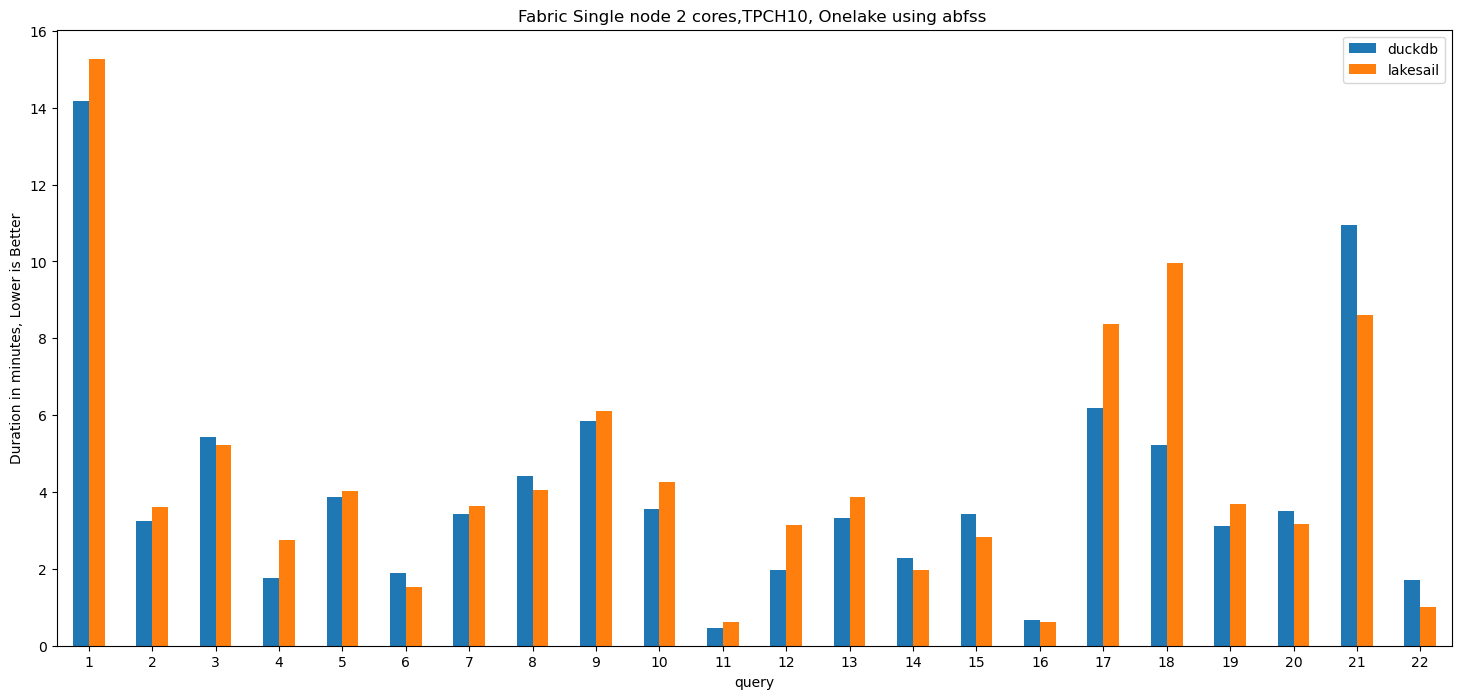

In [27]:
t=con.sql("""
    pivot (select Engine,query, avg(dur) as dur from raw group by all) on Engine using avg(dur)  order by query
""").df()
ax =t.plot.bar(rot=0,x='query',title=f"Fabric Single node {core} cores,TPCH{SF}, Onelake using abfss ",ylabel='Duration in minutes, Lower is Better',figsize=(18,8))

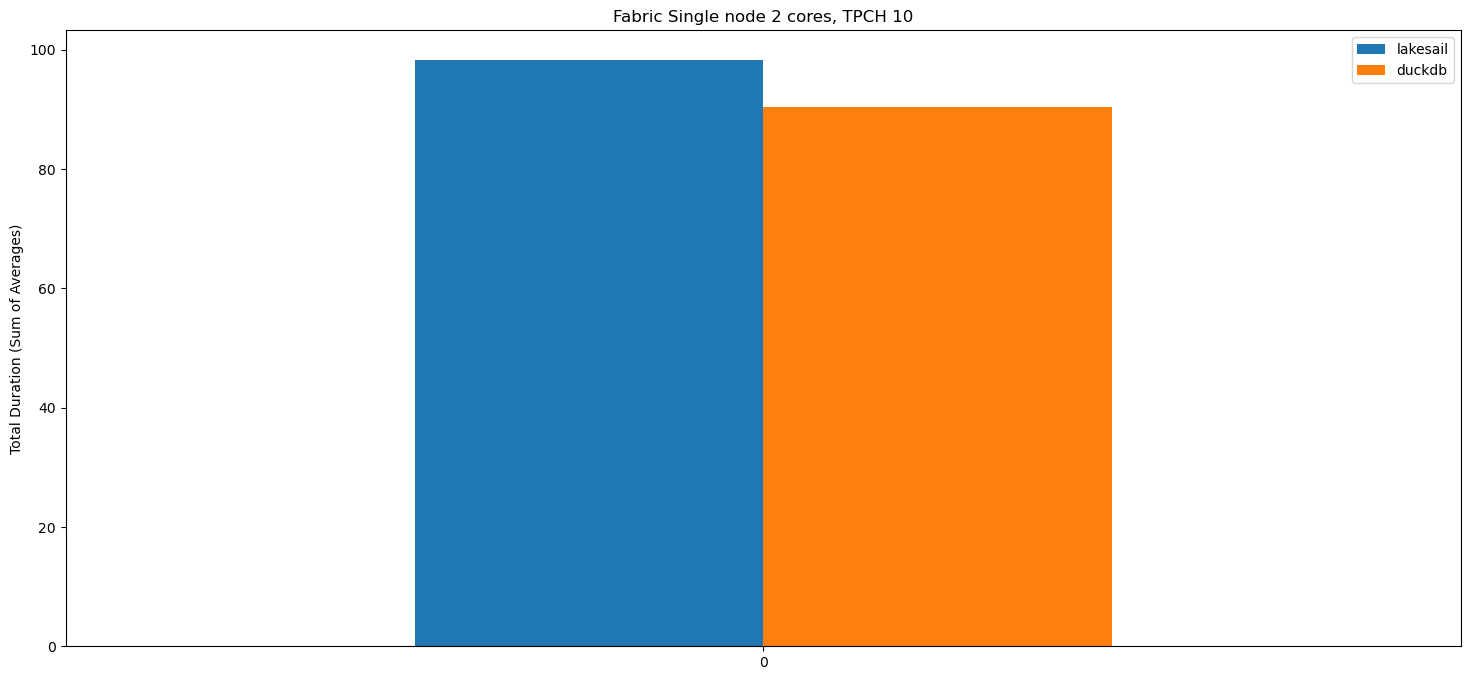

In [37]:
# 1. Create a temp table to hold the averages (Average first)
# This solves the Catalog Error because 'cc' will now exist in the database
con.execute("""
    CREATE OR REPLACE TEMP TABLE cc AS 
    SELECT Engine, query, AVG(dur) as dur 
    FROM raw 
    GROUP BY ALL
""")

# 2. Pivot using SUM to get the total (Sum second)
# No 'GROUP BY' at the end ensures a single row result
s = con.sql("""
    PIVOT (select *exclude(query) from cc) 
    ON Engine IN (
        SELECT Engine FROM cc 
        GROUP BY Engine 
        ORDER BY SUM(dur) DESC
    )
    USING SUM(dur)
""").df()

# Plotting the single row result
ax = s.plot.bar(
    rot=0,
    title=f"Fabric Single node {core} cores, TPCH {SF}",
    ylabel='Total Duration (Sum of Averages)',
    figsize=(18,8)
)